In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

from feature_engine.encoding import RareLabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import catboost
from catboost import Pool, cv
import optuna
from optuna import Trial


from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, precision_score, precision_recall_curve, f1_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score, plot_precision_recall_curve

In [2]:
df = pd.read_csv(r'C:\Users\victo\Desktop\kaggle\coupon\in-vehicle-coupon-recommendation.csv')

In [3]:
df= pd.get_dummies(df,columns =['gender','expiration'],drop_first=True )
df.drop(columns = ['direction_opp','car',],inplace=True)

In [4]:
print(df.nunique(axis=0))

destination              3
passanger                4
weather                  3
temperature              3
time                     5
coupon                   5
age                      8
maritalStatus            5
has_children             2
education                6
occupation              25
income                   9
Bar                      5
CoffeeHouse              5
CarryAway                5
RestaurantLessThan20     5
Restaurant20To50         5
toCoupon_GEQ5min         1
toCoupon_GEQ15min        2
toCoupon_GEQ25min        2
direction_same           2
Y                        2
gender_Male              2
expiration_2h            2
dtype: int64


In [5]:
df.drop(columns = ['toCoupon_GEQ5min'],inplace=True)

In [6]:
def ordinal_encode(data):
    df = data.copy()
    df["age"].replace({'below21': 0, "21": 1, "26":2, "31": 3, "36":4, "41":5,"46":6,"50plus":7}, inplace=True)
    
    df['time'].replace({'2PM': 14, '10AM': 10, "6PM": 18, "7AM": 7, "10PM": 22} , inplace=True)
    
    df['income'].replace({'Less than $12500':0, '$12500 - $24999':1 ,'$25000 - $37499':2,
           '$37500 - $49999':3, '$50000 - $62499':4, '$62500 - $74999':5,
           '$75000 - $87499':6, '$87500 - $99999':7,'$100000 or More':8},inplace=True)
    
    df['education'].replace({'Some High School':0, 'High School Graduate':1 ,'Some college - no degree':2,
           'Associates degree':3, 'Bachelors degree':4, 'Graduate degree (Masters or Doctorate)':5,
                                                                           },inplace=True)
    df['temperature'].replace({30:0, 55:1,80:2},inplace=True)
    return df
df= ordinal_encode(df)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Y']), df.Y.values, test_size=0.30, random_state=714)


In [8]:
def find_freq_cats(df, variable, tolerance):
    temp = df.groupby([variable])[variable].count() / len(df)
    freq = [x for x in temp.loc[temp> tolerance].index.values]
    return freq
labels = find_freq_cats(X_test,'occupation',.06)
labels

['Computer & Mathematical',
 'Education&Training&Library',
 'Management',
 'Sales & Related',
 'Student',
 'Unemployed']

In [9]:
rare_encoder = RareLabelEncoder(tol=.06, variables= ['occupation'])
rare_encoder.fit(X_train)
X_train = rare_encoder.fit_transform(X_train)
X_test = rare_encoder.fit_transform(X_test)

In [10]:
print((X_train.occupation.unique())),((X_test.occupation.unique()))

['Computer & Mathematical' 'Rare' 'Unemployed' 'Student'
 'Education&Training&Library' 'Sales & Related' 'Management']


(None,
 array(['Sales & Related', 'Computer & Mathematical', 'Rare',
        'Education&Training&Library', 'Unemployed', 'Student',
        'Management'], dtype=object))

In [11]:
ohe_cats = ['destination','passanger','weather','coupon','maritalStatus','Bar','CoffeeHouse','CarryAway',
            'RestaurantLessThan20','Restaurant20To50','occupation']

In [12]:
cat_transform = Pipeline(steps = [
                                ('imputer', SimpleImputer(strategy='most_frequent',missing_values=np.nan)),
                                 ('oh_enc', OneHotEncoder(sparse=False))
                                    ])
preprocessor = ColumnTransformer([(
                                    'cats', cat_transform, ohe_cats,)
                                ],remainder="passthrough")

In [14]:
preprocessor.fit(X_train)
X_train_pro = preprocessor.transform(X_train)
X_test_pro = preprocessor.transform(X_test)

In [15]:
(len(X_train_pro))

8878

## Feature Selection

In [19]:
'''rf_clf = RandomForestClassifier() 
rfecv = RFECV(estimator=rf_clf, step=1, cv=5,scoring='roc_auc')   #5-fold cross-validation
rfecv = rfecv.fit(X_train_pro, y_train)'''

In [24]:
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', pd.DataFrame(X_train_pro).columns[rfecv.support_])
best_features = np.array(pd.DataFrame(X_train_pro).columns[rfecv.support_])

Optimal number of features : 50
Best features : Int64Index([ 0,  1,  2,  3,  4,  9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21, 23,
            24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 40, 43, 44, 45,
            46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63],
           dtype='int64')


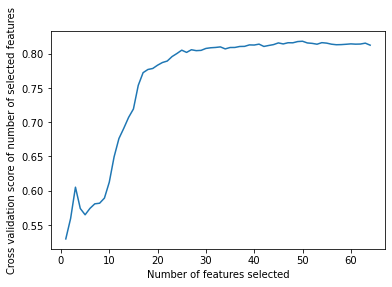

In [29]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
#Overall did not help with model selection after testing

## Model Selection

In [16]:
import lightgbm as gbm

In [17]:
preprocessor.fit(X_train)
X_train_pro = preprocessor.transform(X_train)
X_test_pro = preprocessor.transform(X_test)

In [18]:
len(X_test_pro)

3806

In [19]:
X_train_pro_, X_test_, y_train_, y_test_ = train_test_split(X_train_pro, y_train, test_size=0.30, random_state=714)


In [20]:
SI = Pipeline(steps = [
                                ('imputer', SimpleImputer(strategy='most_frequent',missing_values=np.nan))])
SI.fit(X_train)
X_na = SI.transform(X_train)
X_test_cat = SI.transform(X_test)

X_train_na, X_test_na, y_train_na, y_test_na = train_test_split(X_na, y_train, test_size=0.30, random_state=714)


In [21]:
rf_parms = { 'criterion': 'entropy', 'n_estimators': 3305, 'max_depth': 20, 'max_features': 'sqrt'}
rf_clfer  = RandomForestClassifier(**rf_parms)


xgb_params = {'objective':'binary:logistic','booster': 'gbtree', 'lambda': 3.995352168000524e-05, 'alpha': 1.7796504089335072e-06,
              'subsample': 0.8432765832522267, 'colsample_bytree': 0.6145568641240514, 'learning_rate': 0.021418254141152098, 
              'max_depth': 7, 'gamma': 1.3213282383643845, 'min_child_weight': 0.41928725218821056, 'n_estimators':5000
             }
xgb_clfer =  xgb.XGBClassifier(**xgb_params)



cat_params = {'objective': 'Logloss', 'colsample_bylevel': 0.09924752074817642, 'depth': 7, 
              'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4969870635599054,"n_estimators" : 2000
             #'eval_metric' :'AUC'
             }
cat_clfer =catboost.CatBoostClassifier(**cat_params)

cat_features = np.arange(0,21)
lgb_params={'objective': 'binary', 'metric': 'binary_logloss', 
           'verbosity': -1, 'boosting_type': 'gbdt', 'device_type': 'gpu', 
           'feature_pre_filter': False,'lambda_l1': 1.1510937191844763e-08,
           'lambda_l2': 2.7256100916312845e-08, 'num_leaves': 31, 
           'feature_fraction': 0.7, 'bagging_fraction': 0.9298048538046241,
           'bagging_freq': 3, 'min_child_samples': 20, 'n_estimators':5000}

gbm_clfer = gbm.LGBMClassifier(**lgb_params)



In [22]:
xgb_clfer.fit(X_train_pro_, y_train_,eval_set=[(X_test_, y_test_)],early_stopping_rounds=50,eval_metric=['auc'])
rf_clfer.fit(X_train_pro,y_train)
gbm_clfer.fit(X_train_pro_, y_train_,eval_set=[(X_test_, y_test_)],early_stopping_rounds=50,eval_metric=['auc'])
cat_clfer.fit(X_train_na,y_train_na,cat_features= cat_features,eval_set=[(X_test_na,y_test_na)],
              early_stopping_rounds=50,plot=False)

[0]	validation_0-auc:0.72412
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.73141
[2]	validation_0-auc:0.74979
[3]	validation_0-auc:0.76405
[4]	validation_0-auc:0.77159
[5]	validation_0-auc:0.77624
[6]	validation_0-auc:0.77958
[7]	validation_0-auc:0.78164
[8]	validation_0-auc:0.78196
[9]	validation_0-auc:0.78314
[10]	validation_0-auc:0.78509
[11]	validation_0-auc:0.78644
[12]	validation_0-auc:0.78729
[13]	validation_0-auc:0.78693
[14]	validation_0-auc:0.78736
[15]	validation_0-auc:0.78717
[16]	validation_0-auc:0.78831
[17]	validation_0-auc:0.78825
[18]	validation_0-auc:0.78946
[19]	validation_0-auc:0.78940
[20]	validation_0-auc:0.78901
[21]	validation_0-auc:0.78842
[22]	validation_0-auc:0.78870
[23]	validation_0-auc:0.78914
[24]	validation_0-auc:0.78983
[25]	validation_0-auc:0.78994
[26]	validation_0-auc:0.78995
[27]	validation_0-auc:0.78979
[28]	validation_0-auc:0.79019
[29]	validation_0-auc:0.78969
[30]	validation_0-auc:0.78992
[31]	validation_

[266]	validation_0-auc:0.82322
[267]	validation_0-auc:0.82322
[268]	validation_0-auc:0.82335
[269]	validation_0-auc:0.82350
[270]	validation_0-auc:0.82359
[271]	validation_0-auc:0.82367
[272]	validation_0-auc:0.82360
[273]	validation_0-auc:0.82360
[274]	validation_0-auc:0.82378
[275]	validation_0-auc:0.82415
[276]	validation_0-auc:0.82436
[277]	validation_0-auc:0.82450
[278]	validation_0-auc:0.82446
[279]	validation_0-auc:0.82453
[280]	validation_0-auc:0.82456
[281]	validation_0-auc:0.82466
[282]	validation_0-auc:0.82471
[283]	validation_0-auc:0.82480
[284]	validation_0-auc:0.82473
[285]	validation_0-auc:0.82474
[286]	validation_0-auc:0.82486
[287]	validation_0-auc:0.82490
[288]	validation_0-auc:0.82502
[289]	validation_0-auc:0.82517
[290]	validation_0-auc:0.82522
[291]	validation_0-auc:0.82536
[292]	validation_0-auc:0.82529
[293]	validation_0-auc:0.82535
[294]	validation_0-auc:0.82536
[295]	validation_0-auc:0.82527
[296]	validation_0-auc:0.82524
[297]	validation_0-auc:0.82530
[298]	va

[531]	validation_0-auc:0.83121
[532]	validation_0-auc:0.83122
[533]	validation_0-auc:0.83126
[534]	validation_0-auc:0.83133
[535]	validation_0-auc:0.83132
[536]	validation_0-auc:0.83129
[537]	validation_0-auc:0.83126
[538]	validation_0-auc:0.83124
[539]	validation_0-auc:0.83125
[540]	validation_0-auc:0.83128
[541]	validation_0-auc:0.83131
[542]	validation_0-auc:0.83134
[543]	validation_0-auc:0.83128
[544]	validation_0-auc:0.83137
[545]	validation_0-auc:0.83143
[546]	validation_0-auc:0.83139
[547]	validation_0-auc:0.83135
[548]	validation_0-auc:0.83139
[549]	validation_0-auc:0.83139
[550]	validation_0-auc:0.83144
[551]	validation_0-auc:0.83142
[552]	validation_0-auc:0.83149
[553]	validation_0-auc:0.83146
[554]	validation_0-auc:0.83141
[555]	validation_0-auc:0.83142
[556]	validation_0-auc:0.83144
[557]	validation_0-auc:0.83147
[558]	validation_0-auc:0.83150
[559]	validation_0-auc:0.83150
[560]	validation_0-auc:0.83152
[561]	validation_0-auc:0.83151
[562]	validation_0-auc:0.83149
[563]	va

[52]	valid_0's auc: 0.804532	valid_0's binary_logloss: 0.535838
[53]	valid_0's auc: 0.805549	valid_0's binary_logloss: 0.534725
[54]	valid_0's auc: 0.805318	valid_0's binary_logloss: 0.534793
[55]	valid_0's auc: 0.805893	valid_0's binary_logloss: 0.534035
[56]	valid_0's auc: 0.805919	valid_0's binary_logloss: 0.533881
[57]	valid_0's auc: 0.806562	valid_0's binary_logloss: 0.533267
[58]	valid_0's auc: 0.807067	valid_0's binary_logloss: 0.532384
[59]	valid_0's auc: 0.807517	valid_0's binary_logloss: 0.531687
[60]	valid_0's auc: 0.80739	valid_0's binary_logloss: 0.531543
[61]	valid_0's auc: 0.808004	valid_0's binary_logloss: 0.531063
[62]	valid_0's auc: 0.808362	valid_0's binary_logloss: 0.530561
[63]	valid_0's auc: 0.808693	valid_0's binary_logloss: 0.530278
[64]	valid_0's auc: 0.808797	valid_0's binary_logloss: 0.530118
[65]	valid_0's auc: 0.808441	valid_0's binary_logloss: 0.530328
[66]	valid_0's auc: 0.808604	valid_0's binary_logloss: 0.529988
[67]	valid_0's auc: 0.810049	valid_0's bi

[195]	valid_0's auc: 0.825959	valid_0's binary_logloss: 0.504446
[196]	valid_0's auc: 0.825999	valid_0's binary_logloss: 0.504301
[197]	valid_0's auc: 0.826161	valid_0's binary_logloss: 0.504052
[198]	valid_0's auc: 0.826022	valid_0's binary_logloss: 0.504214
[199]	valid_0's auc: 0.825997	valid_0's binary_logloss: 0.504185
[200]	valid_0's auc: 0.826181	valid_0's binary_logloss: 0.503945
[201]	valid_0's auc: 0.825942	valid_0's binary_logloss: 0.504196
[202]	valid_0's auc: 0.826041	valid_0's binary_logloss: 0.504119
[203]	valid_0's auc: 0.826283	valid_0's binary_logloss: 0.503812
[204]	valid_0's auc: 0.826275	valid_0's binary_logloss: 0.503811
[205]	valid_0's auc: 0.826252	valid_0's binary_logloss: 0.503852
[206]	valid_0's auc: 0.826466	valid_0's binary_logloss: 0.503516
[207]	valid_0's auc: 0.826374	valid_0's binary_logloss: 0.503652
[208]	valid_0's auc: 0.826398	valid_0's binary_logloss: 0.503629
[209]	valid_0's auc: 0.826452	valid_0's binary_logloss: 0.503544
[210]	valid_0's auc: 0.82

33:	learn: 0.6255671	test: 0.6267396	best: 0.6267396 (33)	total: 803ms	remaining: 46.4s
34:	learn: 0.6246518	test: 0.6258122	best: 0.6258122 (34)	total: 814ms	remaining: 45.7s
35:	learn: 0.6239284	test: 0.6250323	best: 0.6250323 (35)	total: 823ms	remaining: 44.9s
36:	learn: 0.6228213	test: 0.6240410	best: 0.6240410 (36)	total: 842ms	remaining: 44.7s
37:	learn: 0.6213826	test: 0.6226377	best: 0.6226377 (37)	total: 869ms	remaining: 44.9s
38:	learn: 0.6210303	test: 0.6222220	best: 0.6222220 (38)	total: 874ms	remaining: 43.9s
39:	learn: 0.6198997	test: 0.6212080	best: 0.6212080 (39)	total: 898ms	remaining: 44s
40:	learn: 0.6183769	test: 0.6196417	best: 0.6196417 (40)	total: 924ms	remaining: 44.1s
41:	learn: 0.6166207	test: 0.6177350	best: 0.6177350 (41)	total: 951ms	remaining: 44.3s
42:	learn: 0.6155209	test: 0.6164280	best: 0.6164280 (42)	total: 976ms	remaining: 44.4s
43:	learn: 0.6146078	test: 0.6152831	best: 0.6152831 (43)	total: 996ms	remaining: 44.3s
44:	learn: 0.6144631	test: 0.61509

136:	learn: 0.5794543	test: 0.5841147	best: 0.5841147 (136)	total: 2.44s	remaining: 33.2s
137:	learn: 0.5794133	test: 0.5841032	best: 0.5841032 (137)	total: 2.45s	remaining: 33s
138:	learn: 0.5791632	test: 0.5839727	best: 0.5839727 (138)	total: 2.47s	remaining: 33.1s
139:	learn: 0.5784823	test: 0.5835900	best: 0.5835900 (139)	total: 2.5s	remaining: 33.2s
140:	learn: 0.5783874	test: 0.5834922	best: 0.5834922 (140)	total: 2.51s	remaining: 33.1s
141:	learn: 0.5781442	test: 0.5833194	best: 0.5833194 (141)	total: 2.54s	remaining: 33.2s
142:	learn: 0.5781442	test: 0.5833194	best: 0.5833194 (142)	total: 2.54s	remaining: 33s
143:	learn: 0.5781285	test: 0.5832867	best: 0.5832867 (143)	total: 2.55s	remaining: 32.8s
144:	learn: 0.5775864	test: 0.5828683	best: 0.5828683 (144)	total: 2.58s	remaining: 33s
145:	learn: 0.5775338	test: 0.5828043	best: 0.5828043 (145)	total: 2.59s	remaining: 32.9s
146:	learn: 0.5775269	test: 0.5828073	best: 0.5828043 (145)	total: 2.6s	remaining: 32.8s
147:	learn: 0.5775

232:	learn: 0.5654718	test: 0.5736144	best: 0.5736144 (232)	total: 3.75s	remaining: 28.4s
233:	learn: 0.5654718	test: 0.5736145	best: 0.5736144 (232)	total: 3.75s	remaining: 28.3s
234:	learn: 0.5651979	test: 0.5732480	best: 0.5732480 (234)	total: 3.76s	remaining: 28.2s
235:	learn: 0.5649089	test: 0.5729951	best: 0.5729951 (235)	total: 3.79s	remaining: 28.3s
236:	learn: 0.5649089	test: 0.5729953	best: 0.5729951 (235)	total: 3.79s	remaining: 28.2s
237:	learn: 0.5648930	test: 0.5729760	best: 0.5729760 (237)	total: 3.79s	remaining: 28.1s
238:	learn: 0.5646874	test: 0.5727861	best: 0.5727861 (238)	total: 3.81s	remaining: 28.1s
239:	learn: 0.5646637	test: 0.5727892	best: 0.5727861 (238)	total: 3.82s	remaining: 28s
240:	learn: 0.5645278	test: 0.5726383	best: 0.5726383 (240)	total: 3.83s	remaining: 28s
241:	learn: 0.5644130	test: 0.5726067	best: 0.5726067 (241)	total: 3.85s	remaining: 28s
242:	learn: 0.5644130	test: 0.5726067	best: 0.5726067 (241)	total: 3.85s	remaining: 27.9s
243:	learn: 0.56

331:	learn: 0.5398607	test: 0.5586811	best: 0.5586811 (331)	total: 5.65s	remaining: 28.4s
332:	learn: 0.5397412	test: 0.5586239	best: 0.5586239 (332)	total: 5.68s	remaining: 28.4s
333:	learn: 0.5397412	test: 0.5586238	best: 0.5586238 (333)	total: 5.68s	remaining: 28.3s
334:	learn: 0.5393285	test: 0.5584362	best: 0.5584362 (334)	total: 5.71s	remaining: 28.4s
335:	learn: 0.5390921	test: 0.5583894	best: 0.5583894 (335)	total: 5.74s	remaining: 28.4s
336:	learn: 0.5386515	test: 0.5581634	best: 0.5581634 (336)	total: 5.76s	remaining: 28.4s
337:	learn: 0.5383576	test: 0.5578910	best: 0.5578910 (337)	total: 5.78s	remaining: 28.4s
338:	learn: 0.5378027	test: 0.5575575	best: 0.5575575 (338)	total: 5.8s	remaining: 28.4s
339:	learn: 0.5376621	test: 0.5574893	best: 0.5574893 (339)	total: 5.83s	remaining: 28.5s
340:	learn: 0.5373583	test: 0.5572790	best: 0.5572790 (340)	total: 5.86s	remaining: 28.5s
341:	learn: 0.5370818	test: 0.5571572	best: 0.5571572 (341)	total: 5.88s	remaining: 28.5s
342:	learn:

428:	learn: 0.5149406	test: 0.5471346	best: 0.5471346 (428)	total: 7.93s	remaining: 29s
429:	learn: 0.5145627	test: 0.5470175	best: 0.5470175 (429)	total: 7.95s	remaining: 29s
430:	learn: 0.5145627	test: 0.5470179	best: 0.5470175 (429)	total: 7.95s	remaining: 29s
431:	learn: 0.5142914	test: 0.5468773	best: 0.5468773 (431)	total: 7.98s	remaining: 29s
432:	learn: 0.5142914	test: 0.5468777	best: 0.5468773 (431)	total: 7.98s	remaining: 28.9s
433:	learn: 0.5142914	test: 0.5468780	best: 0.5468773 (431)	total: 7.98s	remaining: 28.8s
434:	learn: 0.5141814	test: 0.5468009	best: 0.5468009 (434)	total: 8.01s	remaining: 28.8s
435:	learn: 0.5140138	test: 0.5467048	best: 0.5467048 (435)	total: 8.03s	remaining: 28.8s
436:	learn: 0.5136657	test: 0.5464655	best: 0.5464655 (436)	total: 8.06s	remaining: 28.8s
437:	learn: 0.5133975	test: 0.5463235	best: 0.5463235 (437)	total: 8.09s	remaining: 28.9s
438:	learn: 0.5130146	test: 0.5461118	best: 0.5461118 (438)	total: 8.12s	remaining: 28.9s
439:	learn: 0.5125

524:	learn: 0.4934111	test: 0.5387253	best: 0.5387253 (524)	total: 10s	remaining: 28.1s
525:	learn: 0.4933269	test: 0.5386788	best: 0.5386788 (525)	total: 10s	remaining: 28.1s
526:	learn: 0.4929844	test: 0.5385453	best: 0.5385453 (526)	total: 10.1s	remaining: 28.1s
527:	learn: 0.4929106	test: 0.5385217	best: 0.5385217 (527)	total: 10.1s	remaining: 28.1s
528:	learn: 0.4929106	test: 0.5385220	best: 0.5385217 (527)	total: 10.1s	remaining: 28s
529:	learn: 0.4926535	test: 0.5382150	best: 0.5382150 (529)	total: 10.1s	remaining: 28s
530:	learn: 0.4924628	test: 0.5381799	best: 0.5381799 (530)	total: 10.1s	remaining: 28s
531:	learn: 0.4920946	test: 0.5380918	best: 0.5380918 (531)	total: 10.2s	remaining: 28s
532:	learn: 0.4919751	test: 0.5380289	best: 0.5380289 (532)	total: 10.2s	remaining: 28s
533:	learn: 0.4918309	test: 0.5380063	best: 0.5380063 (533)	total: 10.2s	remaining: 28s
534:	learn: 0.4914257	test: 0.5379078	best: 0.5379078 (534)	total: 10.2s	remaining: 28s
535:	learn: 0.4912718	test: 

620:	learn: 0.4744350	test: 0.5319890	best: 0.5319890 (620)	total: 12.1s	remaining: 26.9s
621:	learn: 0.4742451	test: 0.5319199	best: 0.5319199 (621)	total: 12.1s	remaining: 26.9s
622:	learn: 0.4741050	test: 0.5317745	best: 0.5317745 (622)	total: 12.2s	remaining: 26.9s
623:	learn: 0.4741050	test: 0.5317746	best: 0.5317745 (622)	total: 12.2s	remaining: 26.8s
624:	learn: 0.4739514	test: 0.5317122	best: 0.5317122 (624)	total: 12.2s	remaining: 26.8s
625:	learn: 0.4737305	test: 0.5316283	best: 0.5316283 (625)	total: 12.2s	remaining: 26.8s
626:	learn: 0.4735526	test: 0.5314943	best: 0.5314943 (626)	total: 12.2s	remaining: 26.8s
627:	learn: 0.4733610	test: 0.5314650	best: 0.5314650 (627)	total: 12.3s	remaining: 26.8s
628:	learn: 0.4729899	test: 0.5314813	best: 0.5314650 (627)	total: 12.3s	remaining: 26.8s
629:	learn: 0.4728203	test: 0.5314224	best: 0.5314224 (629)	total: 12.3s	remaining: 26.8s
630:	learn: 0.4726808	test: 0.5313838	best: 0.5313838 (630)	total: 12.3s	remaining: 26.8s
631:	learn

713:	learn: 0.4585056	test: 0.5275835	best: 0.5275835 (713)	total: 14.4s	remaining: 25.9s
714:	learn: 0.4582736	test: 0.5274974	best: 0.5274974 (714)	total: 14.4s	remaining: 25.9s
715:	learn: 0.4580636	test: 0.5274631	best: 0.5274631 (715)	total: 14.4s	remaining: 25.9s
716:	learn: 0.4579884	test: 0.5274314	best: 0.5274314 (716)	total: 14.5s	remaining: 25.9s
717:	learn: 0.4578654	test: 0.5273912	best: 0.5273912 (717)	total: 14.5s	remaining: 25.9s
718:	learn: 0.4576721	test: 0.5273860	best: 0.5273860 (718)	total: 14.5s	remaining: 25.9s
719:	learn: 0.4575949	test: 0.5273898	best: 0.5273860 (718)	total: 14.5s	remaining: 25.9s
720:	learn: 0.4574599	test: 0.5273290	best: 0.5273290 (720)	total: 14.6s	remaining: 25.9s
721:	learn: 0.4573681	test: 0.5273086	best: 0.5273086 (721)	total: 14.6s	remaining: 25.8s
722:	learn: 0.4570869	test: 0.5273025	best: 0.5273025 (722)	total: 14.6s	remaining: 25.8s
723:	learn: 0.4569779	test: 0.5272500	best: 0.5272500 (723)	total: 14.6s	remaining: 25.8s
724:	learn

812:	learn: 0.4433190	test: 0.5245338	best: 0.5245338 (812)	total: 16.9s	remaining: 24.6s
813:	learn: 0.4432556	test: 0.5245421	best: 0.5245338 (812)	total: 16.9s	remaining: 24.6s
814:	learn: 0.4431937	test: 0.5245292	best: 0.5245292 (814)	total: 16.9s	remaining: 24.6s
815:	learn: 0.4429896	test: 0.5244542	best: 0.5244542 (815)	total: 16.9s	remaining: 24.6s
816:	learn: 0.4427616	test: 0.5243940	best: 0.5243940 (816)	total: 17s	remaining: 24.6s
817:	learn: 0.4427605	test: 0.5243958	best: 0.5243940 (816)	total: 17s	remaining: 24.5s
818:	learn: 0.4427193	test: 0.5243995	best: 0.5243940 (816)	total: 17s	remaining: 24.5s
819:	learn: 0.4424607	test: 0.5243954	best: 0.5243940 (816)	total: 17s	remaining: 24.5s
820:	learn: 0.4424607	test: 0.5243958	best: 0.5243940 (816)	total: 17s	remaining: 24.5s
821:	learn: 0.4422599	test: 0.5243184	best: 0.5243184 (821)	total: 17.1s	remaining: 24.4s
822:	learn: 0.4422599	test: 0.5243186	best: 0.5243184 (821)	total: 17.1s	remaining: 24.4s
823:	learn: 0.441714

906:	learn: 0.4298066	test: 0.5214389	best: 0.5214389 (906)	total: 18.9s	remaining: 22.8s
907:	learn: 0.4297492	test: 0.5213884	best: 0.5213884 (907)	total: 18.9s	remaining: 22.8s
908:	learn: 0.4297291	test: 0.5213885	best: 0.5213884 (907)	total: 19s	remaining: 22.7s
909:	learn: 0.4297291	test: 0.5213889	best: 0.5213884 (907)	total: 19s	remaining: 22.7s
910:	learn: 0.4296075	test: 0.5214197	best: 0.5213884 (907)	total: 19s	remaining: 22.7s
911:	learn: 0.4294610	test: 0.5213260	best: 0.5213260 (911)	total: 19s	remaining: 22.7s
912:	learn: 0.4291620	test: 0.5213801	best: 0.5213260 (911)	total: 19s	remaining: 22.7s
913:	learn: 0.4291365	test: 0.5213468	best: 0.5213260 (911)	total: 19.1s	remaining: 22.7s
914:	learn: 0.4289123	test: 0.5212780	best: 0.5212780 (914)	total: 19.1s	remaining: 22.6s
915:	learn: 0.4289123	test: 0.5212783	best: 0.5212780 (914)	total: 19.1s	remaining: 22.6s
916:	learn: 0.4286560	test: 0.5212752	best: 0.5212752 (916)	total: 19.1s	remaining: 22.6s
917:	learn: 0.428446

1006:	learn: 0.4182081	test: 0.5200559	best: 0.5200557 (1005)	total: 21.4s	remaining: 21.1s
1007:	learn: 0.4181000	test: 0.5200390	best: 0.5200390 (1007)	total: 21.4s	remaining: 21.1s
1008:	learn: 0.4180880	test: 0.5200370	best: 0.5200370 (1008)	total: 21.5s	remaining: 21.1s
1009:	learn: 0.4180620	test: 0.5200386	best: 0.5200370 (1008)	total: 21.5s	remaining: 21.1s
1010:	learn: 0.4179837	test: 0.5199897	best: 0.5199897 (1010)	total: 21.5s	remaining: 21.1s
1011:	learn: 0.4179159	test: 0.5200279	best: 0.5199897 (1010)	total: 21.6s	remaining: 21s
1012:	learn: 0.4176953	test: 0.5200051	best: 0.5199897 (1010)	total: 21.6s	remaining: 21s
1013:	learn: 0.4174291	test: 0.5199686	best: 0.5199686 (1013)	total: 21.6s	remaining: 21s
1014:	learn: 0.4172563	test: 0.5199174	best: 0.5199174 (1014)	total: 21.6s	remaining: 21s
1015:	learn: 0.4169605	test: 0.5198951	best: 0.5198951 (1015)	total: 21.7s	remaining: 21s
1016:	learn: 0.4168786	test: 0.5198958	best: 0.5198951 (1015)	total: 21.7s	remaining: 21s


1102:	learn: 0.4070084	test: 0.5178441	best: 0.5177842 (1101)	total: 23.7s	remaining: 19.3s
1103:	learn: 0.4068797	test: 0.5177893	best: 0.5177842 (1101)	total: 23.8s	remaining: 19.3s
1104:	learn: 0.4067907	test: 0.5177688	best: 0.5177688 (1104)	total: 23.8s	remaining: 19.3s
1105:	learn: 0.4067889	test: 0.5177689	best: 0.5177688 (1104)	total: 23.8s	remaining: 19.2s
1106:	learn: 0.4067880	test: 0.5177686	best: 0.5177686 (1106)	total: 23.8s	remaining: 19.2s
1107:	learn: 0.4065210	test: 0.5177270	best: 0.5177270 (1107)	total: 23.8s	remaining: 19.2s
1108:	learn: 0.4064459	test: 0.5176866	best: 0.5176866 (1108)	total: 23.9s	remaining: 19.2s
1109:	learn: 0.4063141	test: 0.5176917	best: 0.5176866 (1108)	total: 23.9s	remaining: 19.2s
1110:	learn: 0.4062319	test: 0.5176559	best: 0.5176559 (1110)	total: 23.9s	remaining: 19.2s
1111:	learn: 0.4060486	test: 0.5175658	best: 0.5175658 (1111)	total: 24s	remaining: 19.1s
1112:	learn: 0.4058626	test: 0.5175377	best: 0.5175377 (1112)	total: 24s	remaining

1199:	learn: 0.3964226	test: 0.5156584	best: 0.5156485 (1198)	total: 25.9s	remaining: 17.3s
1200:	learn: 0.3961836	test: 0.5156771	best: 0.5156485 (1198)	total: 25.9s	remaining: 17.2s
1201:	learn: 0.3961316	test: 0.5156574	best: 0.5156485 (1198)	total: 25.9s	remaining: 17.2s
1202:	learn: 0.3961205	test: 0.5156596	best: 0.5156485 (1198)	total: 26s	remaining: 17.2s
1203:	learn: 0.3961205	test: 0.5156598	best: 0.5156485 (1198)	total: 26s	remaining: 17.2s
1204:	learn: 0.3961205	test: 0.5156600	best: 0.5156485 (1198)	total: 26s	remaining: 17.1s
1205:	learn: 0.3960571	test: 0.5156535	best: 0.5156485 (1198)	total: 26s	remaining: 17.1s
1206:	learn: 0.3959825	test: 0.5156455	best: 0.5156455 (1206)	total: 26s	remaining: 17.1s
1207:	learn: 0.3957542	test: 0.5156365	best: 0.5156365 (1207)	total: 26s	remaining: 17.1s
1208:	learn: 0.3957542	test: 0.5156366	best: 0.5156365 (1207)	total: 26s	remaining: 17s
1209:	learn: 0.3956716	test: 0.5156307	best: 0.5156307 (1209)	total: 26.1s	remaining: 17s
1210:	

1293:	learn: 0.3862580	test: 0.5135950	best: 0.5135950 (1293)	total: 28s	remaining: 15.3s
1294:	learn: 0.3862027	test: 0.5135943	best: 0.5135943 (1294)	total: 28s	remaining: 15.3s
1295:	learn: 0.3861739	test: 0.5135983	best: 0.5135943 (1294)	total: 28.1s	remaining: 15.2s
1296:	learn: 0.3861739	test: 0.5135985	best: 0.5135943 (1294)	total: 28.1s	remaining: 15.2s
1297:	learn: 0.3859401	test: 0.5135608	best: 0.5135608 (1297)	total: 28.1s	remaining: 15.2s
1298:	learn: 0.3859401	test: 0.5135611	best: 0.5135608 (1297)	total: 28.1s	remaining: 15.2s
1299:	learn: 0.3859368	test: 0.5135613	best: 0.5135608 (1297)	total: 28.1s	remaining: 15.1s
1300:	learn: 0.3858426	test: 0.5135426	best: 0.5135426 (1300)	total: 28.1s	remaining: 15.1s
1301:	learn: 0.3856469	test: 0.5134750	best: 0.5134750 (1301)	total: 28.1s	remaining: 15.1s
1302:	learn: 0.3856469	test: 0.5134751	best: 0.5134750 (1301)	total: 28.1s	remaining: 15.1s
1303:	learn: 0.3854503	test: 0.5134520	best: 0.5134520 (1303)	total: 28.2s	remaining

1391:	learn: 0.3759990	test: 0.5128469	best: 0.5128469 (1391)	total: 30.1s	remaining: 13.2s
1392:	learn: 0.3758588	test: 0.5128075	best: 0.5128075 (1392)	total: 30.2s	remaining: 13.1s
1393:	learn: 0.3758084	test: 0.5128138	best: 0.5128075 (1392)	total: 30.2s	remaining: 13.1s
1394:	learn: 0.3758012	test: 0.5128110	best: 0.5128075 (1392)	total: 30.2s	remaining: 13.1s
1395:	learn: 0.3757897	test: 0.5128126	best: 0.5128075 (1392)	total: 30.2s	remaining: 13.1s
1396:	learn: 0.3757641	test: 0.5128093	best: 0.5128075 (1392)	total: 30.3s	remaining: 13.1s
1397:	learn: 0.3757641	test: 0.5128095	best: 0.5128075 (1392)	total: 30.3s	remaining: 13s
1398:	learn: 0.3757641	test: 0.5128095	best: 0.5128075 (1392)	total: 30.3s	remaining: 13s
1399:	learn: 0.3757640	test: 0.5128097	best: 0.5128075 (1392)	total: 30.3s	remaining: 13s
1400:	learn: 0.3757395	test: 0.5127930	best: 0.5127930 (1400)	total: 30.3s	remaining: 12.9s
1401:	learn: 0.3757272	test: 0.5127927	best: 0.5127927 (1401)	total: 30.3s	remaining: 

1488:	learn: 0.3664620	test: 0.5112828	best: 0.5112796 (1487)	total: 32.4s	remaining: 11.1s
1489:	learn: 0.3664060	test: 0.5113181	best: 0.5112796 (1487)	total: 32.4s	remaining: 11.1s
1490:	learn: 0.3661003	test: 0.5112822	best: 0.5112796 (1487)	total: 32.5s	remaining: 11.1s
1491:	learn: 0.3660253	test: 0.5113249	best: 0.5112796 (1487)	total: 32.5s	remaining: 11.1s
1492:	learn: 0.3659578	test: 0.5112551	best: 0.5112551 (1492)	total: 32.5s	remaining: 11s
1493:	learn: 0.3656632	test: 0.5112226	best: 0.5112226 (1493)	total: 32.6s	remaining: 11s
1494:	learn: 0.3656632	test: 0.5112228	best: 0.5112226 (1493)	total: 32.6s	remaining: 11s
1495:	learn: 0.3654582	test: 0.5111807	best: 0.5111807 (1495)	total: 32.6s	remaining: 11s
1496:	learn: 0.3653641	test: 0.5112392	best: 0.5111807 (1495)	total: 32.6s	remaining: 11s
1497:	learn: 0.3652200	test: 0.5112602	best: 0.5111807 (1495)	total: 32.6s	remaining: 10.9s
1498:	learn: 0.3651910	test: 0.5112618	best: 0.5111807 (1495)	total: 32.7s	remaining: 10.9

1585:	learn: 0.3571279	test: 0.5106726	best: 0.5105080 (1559)	total: 34.6s	remaining: 9.02s
1586:	learn: 0.3571218	test: 0.5106735	best: 0.5105080 (1559)	total: 34.6s	remaining: 9s
1587:	learn: 0.3571213	test: 0.5106749	best: 0.5105080 (1559)	total: 34.6s	remaining: 8.98s
1588:	learn: 0.3571154	test: 0.5106732	best: 0.5105080 (1559)	total: 34.6s	remaining: 8.96s
1589:	learn: 0.3570777	test: 0.5106759	best: 0.5105080 (1559)	total: 34.6s	remaining: 8.93s
1590:	learn: 0.3568847	test: 0.5107470	best: 0.5105080 (1559)	total: 34.7s	remaining: 8.91s
1591:	learn: 0.3568742	test: 0.5107471	best: 0.5105080 (1559)	total: 34.7s	remaining: 8.89s
1592:	learn: 0.3566929	test: 0.5107715	best: 0.5105080 (1559)	total: 34.7s	remaining: 8.87s
1593:	learn: 0.3566309	test: 0.5108167	best: 0.5105080 (1559)	total: 34.7s	remaining: 8.85s
1594:	learn: 0.3565789	test: 0.5108203	best: 0.5105080 (1559)	total: 34.8s	remaining: 8.83s
1595:	learn: 0.3563951	test: 0.5108256	best: 0.5105080 (1559)	total: 34.8s	remainin

In [23]:
cat_best_iter = cat_clfer.get_best_iteration()


In [70]:
rf_preds=rf_clfer.predict_proba(X_train_pro)[:, 1]
xgb_preds=xgb_clfer.predict_proba(X_train_pro,ntree_limit=xgb_clfer.best_ntree_limit)[:, 1]
gbm_preds=gbm_clfer.predict_proba(X_train_pro)[:, 1]
cat_preds=cat_clfer.predict_proba(X_train_na,ntree_end=cat_best_iter)[:, 1]

In [71]:
print('Random Forest AUC SCORE: ', roc_auc_score(y_train, rf_clfer.predict_proba(X_train_pro)[:, 1]))
print('XGB AUC SCORE: ', roc_auc_score(y_train, xgb_clfer.predict_proba(X_train_pro,ntree_limit=xgb_clfer.best_ntree_limit)[:, 1]))
print('GBM AUC SCORE: ', roc_auc_score(y_train,  gbm_clfer.predict_proba(X_train_pro)[:, 1]))
print('CAT AUC SCORE: ', roc_auc_score(y_train,  cat_clfer.predict_proba(X_na,ntree_end=cat_best_iter)[:, 1]))

Random Forest AUC SCORE:  0.9999976486633866
XGB AUC SCORE:  0.9545693601925221
GBM AUC SCORE:  0.939167381886419
CAT AUC SCORE:  0.8673809717231875


In [26]:
xgb_fpr, xgb_tpr, xgb_thresold = roc_curve(y_train, xgb_preds)
rf_fpr, rf_tpr, rf_thresold = roc_curve(y_train, rf_preds)
gbm_fpr, gbm_tpr, gbm_thresold = roc_curve(y_train, gbm_preds)
cat_fpr, cat_tpr, cat_thresold = roc_curve(y_train, cat_preds)


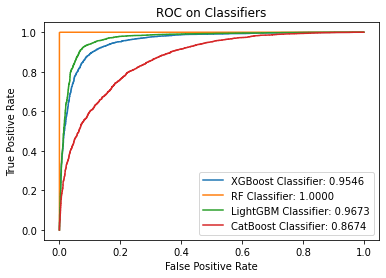

In [233]:
plt.title('ROC on Classifiers')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(xgb_fpr,xgb_tpr, label = 'XGBoost Classifier: {:.4f}'.format( roc_auc_score(y_train, xgb_clfer.predict_proba(X_train_pro)[:, 1])))
plt.plot(rf_fpr,rf_tpr, label = 'RF Classifier: {:.4f}'.format(roc_auc_score(y_train, rf_clfer.predict_proba(X_train_pro)[:, 1])))
plt.plot(gbm_fpr,gbm_tpr, label = 'LightGBM Classifier: {:.4f}'.format(roc_auc_score(y_train,  gbm_clfer.predict_proba(X_train_pro)[:, 1])))
plt.plot(cat_fpr,cat_tpr, label = 'CatBoost Classifier: {:.4f}'.format(roc_auc_score(y_train,  cat_clfer.predict_proba(X_na,ntree_end=cat_best_iter)[:, 1])))

plt.legend()

## Test Set

In [73]:
rf_preds=rf_clfer.predict_proba(X_test_pro)[:, 1]
xgb_preds=xgb_clfer.predict_proba(X_test_pro,ntree_limit=xgb_clfer.best_ntree_limit)[:, 1]
gbm_preds=gbm_clfer.predict_proba(X_test_pro)[:, 1]
cat_preds=cat_clfer.predict_proba(X_test_na,ntree_end=cat_best_iter)[:, 1]

In [28]:
len(X_test_pro)

3806

In [29]:
def show_metrics(y_pred,y_test,clf_name):
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    sns.heatmap((confusion_matrix(y_pred,y_test)),annot= True,cmap='Blues',fmt='g',cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel('True')
    plt.title(f'{clf_name}')
    plt.show()
    print(f'{classification_report(y_pred,y_test)}')

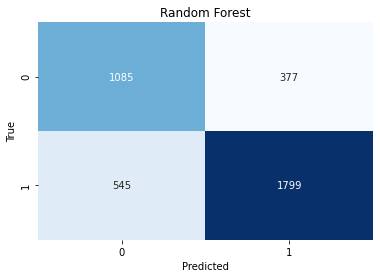

              precision    recall  f1-score   support

           0       0.67      0.74      0.70      1462
           1       0.83      0.77      0.80      2344

    accuracy                           0.76      3806
   macro avg       0.75      0.75      0.75      3806
weighted avg       0.76      0.76      0.76      3806



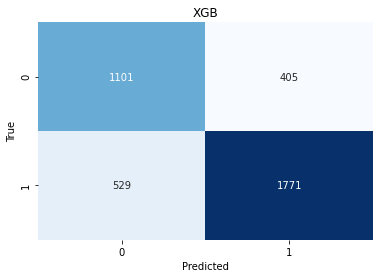

              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1506
           1       0.81      0.77      0.79      2300

    accuracy                           0.75      3806
   macro avg       0.74      0.75      0.75      3806
weighted avg       0.76      0.75      0.76      3806



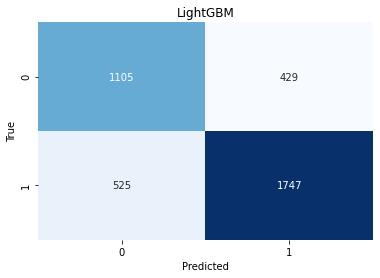

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1534
           1       0.80      0.77      0.79      2272

    accuracy                           0.75      3806
   macro avg       0.74      0.74      0.74      3806
weighted avg       0.75      0.75      0.75      3806



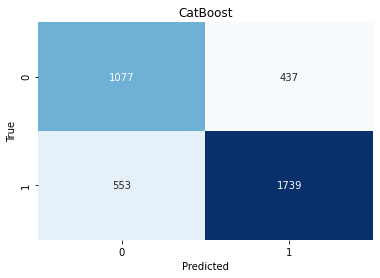

              precision    recall  f1-score   support

           0       0.66      0.71      0.69      1514
           1       0.80      0.76      0.78      2292

    accuracy                           0.74      3806
   macro avg       0.73      0.74      0.73      3806
weighted avg       0.74      0.74      0.74      3806



In [30]:
show_metrics(rf_test_pred,y_test,'Random Forest')
show_metrics(xgb_test_pred,y_test, 'XGB')
show_metrics(gbm_test_pred,y_test,'LightGBM')
show_metrics(cat_test_pred,y_test, 'CatBoost')


In [75]:
rf_auc = roc_auc_score(y_test, rf_preds)
xgb_auc = roc_auc_score(y_test, xgb_preds)
gbm_auc = roc_auc_score(y_test,  gbm_preds)
cat_auc = roc_auc_score(y_test_na,  cat_preds)
roc =[]
roc.append(rf_auc)
roc.append(xgb_auc)
roc.append(gbm_auc)
roc.append(cat_auc)

In [77]:
print(roc)

[0.8261925974377482, 0.8215196172410684, 0.8163760826416456, 0.823103247937169]


In [79]:
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test,rf_preds )
x_fpr, x_tpr, x_threshold = roc_curve(y_test, xgb_preds)
lgb_fpr, lgb_tpr, lgb_threshold = roc_curve(y_test, gbm_preds)
cat_fpr, cat_tpr, cat_threshold = roc_curve(y_test_na, cat_preds)

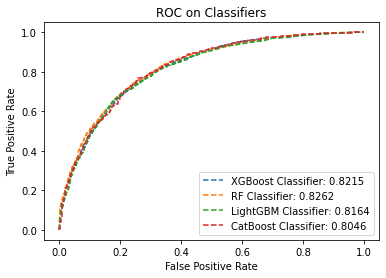

In [80]:
plt.title('ROC on Classifiers')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(x_fpr,x_tpr,linestyle='--', label = 'XGBoost Classifier: {:.4f}'.format( xgb_roc))
plt.plot(rf_fpr,rf_tpr, linestyle='--',label = 'RF Classifier: {:.4f}'.format(rf_roc))
plt.plot(lgb_fpr,lgb_tpr, linestyle='--',label = 'LightGBM Classifier: {:.4f}'.format(gbm_roc))
plt.plot(cat_fpr,cat_tpr, linestyle='--',label = 'CatBoost Classifier: {:.4f}'.format(cat_roc))

plt.legend()

In [49]:
def df_scores(y_pred,y_test):
    precision = []
    recall = []
    f1 = []
    index = []
    f1_ = f1_score(y_pred,y_test)    
    precision_ = precision_score(y_pred,y_test)
    recall_ = recall_score(y_pred,y_test)
    accuracy_score_ = accuracy_score(y_pred,y_test)
    
    '''    df['F1'] = f1
    df['Precision'] = precision
    df['Recall'] = recall
    df['Models'] = index
    df['Accuracy'] = recall'''
    return f1_, precision_, recall_, accuracy_score_

In [50]:
rf_scores = df_scores(rf_test_pred,y_test)
xgb_scores =df_scores(xgb_test_pred,y_test)
gbm_scores = df_scores(gbm_test_pred,y_test)
cat_scores = df_scores(cat_test_pred,y_test)

In [51]:
scores = pd.DataFrame({
    "Random_Forest":rf_scores,
    "XGB": xgb_scores,
    "LightGBM": gbm_scores,
    "CatBoost": cat_scores,
             }).T
scores= scores.rename(columns={0:'F1', 1:'Precision', 2:'Recall', 3: 'Accuracy'})
scores['AUC'] = roc

In [52]:
print(scores.sort_values(by=['AUC','F1'],ascending=False))

                     F1  Precision    Recall  Accuracy       AUC
Random_Forest  0.796018   0.826746  0.767491  0.757751  0.826193
XGB            0.791332   0.813879  0.770000  0.754598  0.821520
LightGBM       0.785522   0.802849  0.768926  0.749343  0.816376
CatBoost       0.778424   0.799173  0.758726  0.739884  0.804576


## Random Forest

In [31]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
    n_estimators = trial.suggest_int('n_estimators', 100, 5000)
    max_depth = trial.suggest_int('max_depth', 5, 35)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    
    model = RandomForestClassifier(n_estimators =n_estimators, max_depth = max_depth, max_features=max_features,criterion =criterion)
    
    score = cross_val_score(model, X_train_pro, y_train, n_jobs=-1, cv=3,scoring= 'roc_auc')
    acc = score.mean()
    return acc

In [32]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=600)

[I 2021-10-04 08:42:47,069] A new study created in memory with name: no-name-b0ad2158-2506-4af9-b37d-880b23f6ec76
[I 2021-10-04 08:42:59,386] Trial 0 finished with value: 0.7880762402094553 and parameters: {'criterion': 'gini', 'n_estimators': 3032, 'max_depth': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7880762402094553.
[I 2021-10-04 08:43:10,168] Trial 1 finished with value: 0.8154542637208535 and parameters: {'criterion': 'entropy', 'n_estimators': 1439, 'max_depth': 28, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8154542637208535.
[I 2021-10-04 08:43:14,548] Trial 2 finished with value: 0.7943649265874165 and parameters: {'criterion': 'entropy', 'n_estimators': 880, 'max_depth': 10, 'max_features': 'auto'}. Best is trial 1 with value: 0.8154542637208535.
[I 2021-10-04 08:43:18,687] Trial 3 finished with value: 0.7800533049105867 and parameters: {'criterion': 'gini', 'n_estimators': 988, 'max_depth': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 

In [25]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 37
Best trial:
  Value: 0.8157916702047502
  Params: 
    criterion: entropy
    n_estimators: 3305
    max_depth: 20
    max_features: auto


## XGB

In [89]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train_pro, label=y_train)
    param = {
        'tree_method' : "gpu_hist",
        'single_precision_histogram' :True,
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        # use exact for small dataset.
        "tree_method": "exact",
        # Dart booster is utilzing dropouts
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "learning_rate" :trial.suggest_loguniform('learning_rate', .005, .05),
        #"n_estimators" : trial.suggest_int('n_estimators', 100, 1500),
        "max_depth" : trial.suggest_int('max_depth', 2, 20),
        "gamma" : trial.suggest_loguniform("gamma", 1e-8, 5.0),
        "min_child_weight" :  trial.suggest_loguniform("min_child_weight", .1, 10.),
    }
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-logloss")
    history = xgb.cv(param, dtrain, num_boost_round=2000,
                     early_stopping_rounds=50,shuffle=True,seed=1, callbacks=[pruning_callback])
    mean_auc = history["test-logloss-mean"].values[-1]
    return mean_auc

In [ ]:
study3 = optuna.create_study(direction="minimize")
study3.optimize(objective, timeout = 3600)

[I 2021-10-15 13:35:32,925] A new study created in memory with name: no-name-f276b33a-a1c3-4cd3-bb54-33d5222a67c5
[I 2021-10-15 13:57:22,163] Trial 0 finished with value: 0.5210753333333332 and parameters: {'booster': 'dart', 'lambda': 1.66172335915631e-05, 'alpha': 0.11714265024181786, 'subsample': 0.5830156502238983, 'colsample_bytree': 0.772992122635445, 'learning_rate': 0.010056019223129717, 'max_depth': 5, 'gamma': 0.0009737616978633545, 'min_child_weight': 9.946103035200492, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.980808072126623e-05, 'skip_drop': 8.577379581466447e-08}. Best is trial 0 with value: 0.5210753333333332.
[I 2021-10-15 13:57:28,796] Trial 1 finished with value: 0.5284939999999999 and parameters: {'booster': 'gbtree', 'lambda': 1.662353660081805e-05, 'alpha': 2.5334679120666368e-05, 'subsample': 0.9006108385118303, 'colsample_bytree': 0.8660974972582443, 'learning_rate': 0.018226227347793156, 'max_depth': 19, 'gamma': 0.0001342832381657939

[I 2021-10-15 14:07:11,077] Trial 38 finished with value: 0.508814 and parameters: {'booster': 'gbtree', 'lambda': 0.00047729785067947695, 'alpha': 0.8372847162601801, 'subsample': 0.6243509925448175, 'colsample_bytree': 0.8411249949174187, 'learning_rate': 0.04886497361963633, 'max_depth': 9, 'gamma': 0.09712965253585162, 'min_child_weight': 0.7359711057870219}. Best is trial 4 with value: 0.5013366666666667.
[I 2021-10-15 14:07:15,762] Trial 39 finished with value: 0.5035543333333333 and parameters: {'booster': 'gbtree', 'lambda': 0.0004925562779487901, 'alpha': 0.623055066505044, 'subsample': 0.6141875430896835, 'colsample_bytree': 0.8250489390678762, 'learning_rate': 0.04920731594163862, 'max_depth': 8, 'gamma': 0.09299394044569205, 'min_child_weight': 0.745472229757054}. Best is trial 4 with value: 0.5013366666666667.
[I 2021-10-15 14:07:17,048] Trial 40 pruned. Trial was pruned at iteration 34.
[I 2021-10-15 14:07:18,221] Trial 41 pruned. Trial was pruned at iteration 52.
[I 2021

[I 2021-10-15 14:08:29,734] Trial 85 pruned. Trial was pruned at iteration 123.
[I 2021-10-15 14:08:29,864] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2021-10-15 14:08:29,965] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2021-10-15 14:08:30,052] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2021-10-15 14:08:30,135] Trial 89 pruned. Trial was pruned at iteration 0.
[I 2021-10-15 14:08:30,234] Trial 90 pruned. Trial was pruned at iteration 0.
[I 2021-10-15 14:08:30,312] Trial 91 pruned. Trial was pruned at iteration 0.
[I 2021-10-15 14:08:30,409] Trial 92 pruned. Trial was pruned at iteration 1.
[I 2021-10-15 14:08:30,497] Trial 93 pruned. Trial was pruned at iteration 0.
[I 2021-10-15 14:08:30,981] Trial 94 pruned. Trial was pruned at iteration 16.
[I 2021-10-15 14:08:31,080] Trial 95 pruned. Trial was pruned at iteration 1.
[I 2021-10-15 14:08:31,244] Trial 96 pruned. Trial was pruned at iteration 4.
[I 2021-10-15 14:08:31,327] Trial 97 pruned. Trial was pruned

In [88]:
xgb_params = {'booster': 'gbtree', 'lambda': 0.00010523703876762463,
              'alpha': 0.0006833753685742218, 'subsample': 0.9349575408814379, 
              'colsample_bytree': 0.34880508674737537, 'learning_rate': 0.009936163323757031,
              'max_depth': 10, 'gamma': 1.410694107976458e-08, 'min_child_weight': 2.987568242939395}

In [ ]:
{'booster': 'dart', 'lambda': 7.575634203369217e-06, 'alpha': 0.001852376539438152,
 'subsample': 0.7809563713602394, 'colsample_bytree': 0.43804511392238177, 'learning_rate': 0.012631027610068696, 
 'max_depth': 8, 'gamma': 5.0444624963719695e-08, 'min_child_weight': 0.3912153668425309, 'sample_type': 'weighted',
 'normalize_type': 'forest', 
 'rate_drop': 1.0565633996719451e-07, 'skip_drop': 0.0013099461918864852}

In [ ]:
print(study3.best_params)    
print(study3.best_value)
print(study3.best_trial)

In [83]:
trial = study.best_trial

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study3.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

## CatBoost

In [18]:
SI = Pipeline(steps = [
                                ('imputer', SimpleImputer(strategy='most_frequent',missing_values=np.nan))])
SI.fit(X_train)
X_na = SI.transform(X_train)

In [19]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X_na, y_train, test_size=0.3)
    param = {
        'n_estimators' : 3000,
        'eval_metric': 'AUC',
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

        
    cat_features = np.arange(0,21)
    gbm = catboost.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y,cat_features=cat_features, eval_set=[(valid_x, valid_y)], verbose=0,
            early_stopping_rounds=100,
           # eval_metrics='AUC'
           )

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = roc_auc_score(valid_y, pred_labels)
    return auc


In [20]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials= 100,timeout=3600)

[I 2021-10-01 08:26:00,780] A new study created in memory with name: no-name-6ef9efb4-3ad2-448f-958a-cd65075b49fe
[I 2021-10-01 08:31:51,901] Trial 0 finished with value: 0.73620320486255 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08574387263369831, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.73620320486255.
[I 2021-10-01 08:32:14,612] Trial 1 finished with value: 0.739855820096002 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04646447474577557, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.16944516960389155}. Best is trial 1 with value: 0.739855820096002.
[I 2021-10-01 08:32:41,283] Trial 2 finished with value: 0.7233003656914894 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09826023742248528, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.739855820096002.
[I 2021-10-01 08:32:42,236] Trial 3 

[I 2021-10-01 08:51:29,285] Trial 27 finished with value: 0.7094723634317135 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08275976090512946, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.428172173223377}. Best is trial 15 with value: 0.7465804055901784.
[I 2021-10-01 08:52:52,653] Trial 28 finished with value: 0.7414334840115189 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.05342445753925103, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 15 with value: 0.7465804055901784.
[I 2021-10-01 08:53:14,178] Trial 29 finished with value: 0.7240427564483232 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.030100367259256584, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8212269064692395}. Best is trial 15 with value: 0.7465804055901784.
[I 2021-10-01 08:55:09,572] Trial 30 finished with value: 0.74314749351

[I 2021-10-01 09:23:51,860] Trial 53 finished with value: 0.7359049855460117 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09155265169462835, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9927620995641748}. Best is trial 44 with value: 0.7497610782579781.
[I 2021-10-01 09:24:56,289] Trial 54 finished with value: 0.7341607128192493 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09686732463087051, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6449862683878503}. Best is trial 44 with value: 0.7497610782579781.
[I 2021-10-01 09:24:56,781] Trial 55 finished with value: 0.5 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.012828212681492014, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.738181636476253}. Best is trial 44 with value: 0.7497610782579781.
[I 2021-10-01 09:25:42,143] Trial 56 finished with value: 0.7390533651156

In [21]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 58
Best trial:
  Value: 0.7514350553617162
  Params: 
    objective: Logloss
    colsample_bylevel: 0.09924752074817642
    depth: 7
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.4969870635599054


## Light

In [37]:
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import KFold

In [38]:
dtrain = lgb.Dataset(X_train_pro, label=y_train)

In [ ]:
import optuna.integration.lightgbm as lgb

dtrain = lgb.Dataset(X_train_pro, label=y_train)
best_params, tuning_history = dict(), list()
params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "device_type": "gpu",
       
    }

tuner = lgb.LightGBMTunerCV(
        params, dtrain, verbose_eval=100, early_stopping_rounds=25, folds=KFold(n_splits=4),time_budget=19800
        )
    

tuner.run()

print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

In [60]:
params ={'objective': 'binary', 'metric': 'binary_logloss', 
           'verbosity': -1, 'boosting_type': 'gbdt', 'device_type': 'gpu', 
           'feature_pre_filter': False,'lambda_l1': 1.1510937191844763e-08,
           'lambda_l2': 2.7256100916312845e-08, 'num_leaves': 31, 
           'feature_fraction': 0.7, 'bagging_fraction': 0.9298048538046241,
           'bagging_freq': 3, 'min_child_samples': 20, 'n_estimators':5000}

In [69]:
roc_auc_score(y_test,  gbm_clfer.predict_proba(X_test_pro)[:, 1])

0.8318536291050163

In [ ]:
def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = RepeatedKFold(n_splits=5, shuffle=True, random_state=1)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)
study = optuna.create_study(direction="maximize",study_name ='LightGBM')
study.optimize(objective, n_trials= 1)